In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import cv2
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import accuracy_score

In [34]:
sign_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No overtaking',
    10: 'No overtaking by vehicles over 3.5 t',
    11: 'Intersection ahead – right-of-way only for this intersection',
    12: 'Priority road – right-of-way on all following intersections',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles of any kind permitted',
    16: 'No vehicles over 3.5 t permitted',
    17: 'No entry',
    18: 'Danger',
    19: 'Curve (left)',
    20: 'Curve (right)',
    21: 'Double curve (first left)',
    22: 'Uneven road',
    23: 'Slipperiness when road is wet or dirty',
    24: 'One-sided road narrowing (right)',
    25: 'Roadworks',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children',
    29: 'Cycles',
    30: 'Slipperiness due to snow or ice',
    31: 'Wild animals',
    32: 'End of all restrictions',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Go straight ahead',
    36: 'Go straight or turn right ahead',
    37: 'Go straight or turn left ahead',
    38: 'Pass on the right',
    39: 'Pass on the left',
    40: 'Roundabout',
    41: 'End of no overtaking',
    42: 'End of no overtaking by vehicles over 3.5 t'
}

categories = {
    'speed_limits': [0,1,2,3,4,5,7,8],
    'prohibitory': [9,10,15,16,17],
    'danger': [18,19,20,21,22,23,24,25,26,27,28,29,30,31],
    'mandatory': [33,34,35,36,37,38,39,40],
    'right_of_way': [11,12,13,14],
    'end_of': [32,41,42,6]
}

def get_category(class_id):
    for category, ids in categories.items():
        if class_id in ids:
            return category
    return 'unknown'

labels_dir = Path("dataset/labels/train")
images_dir = Path("dataset/images/train")

In [35]:
records = []

for label_file in labels_dir.glob("*.txt"):
    with open(label_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, xc, yc, w, h = line.split()
        records.append({
            "image_id": label_file.stem,
            "class_id": int(cls),
            "sign_name": sign_names[int(cls)],
            "category": get_category(int(cls)),
            "xc": float(xc),
            "yc": float(yc),
            "width": float(w),
            "height": float(h),
            "area": float(w) * float(h)
        })

df = pd.DataFrame(records)
df.head()

,image_id,class_id,sign_name,category,xc,yc,width,height,area
0,00000,11,Intersection ahead – right-of-way only for thi...,right_of_way,0.584191,0.535625,0.030147,0.04375,0.001319
1,00001,40,Roundabout,mandatory,0.737868,0.512500,0.030147,0.05500,0.001658
2,00001,38,Pass on the right,mandatory,0.304412,0.653750,0.041176,0.07250,0.002985
3,00001,13,Yield,right_of_way,0.736765,0.453125,0.042647,0.06875,0.002932
4,00003,4,Speed limit (70km/h),speed_limits,0.554044,0.568125,0.016912,0.02875,0.000486


## Analiza eksploracyjna

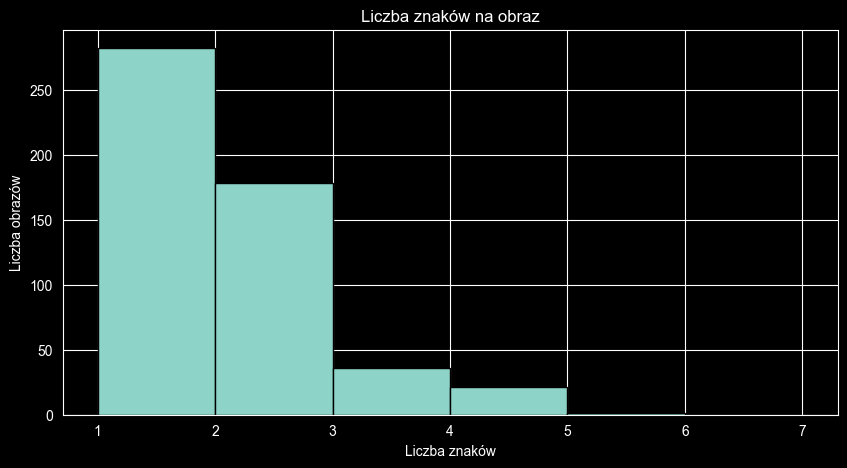

count    518.000000
mean       1.611969
std        0.802566
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
dtype: float64


In [36]:
signs_per_image = df.groupby("image_id").size()

plt.figure(figsize=(10,5))
signs_per_image.plot(kind="hist", bins=range(1,8), edgecolor="black")
plt.title("Liczba znaków na obraz")
plt.xlabel("Liczba znaków")
plt.ylabel("Liczba obrazów")
plt.show()

print(signs_per_image.describe())

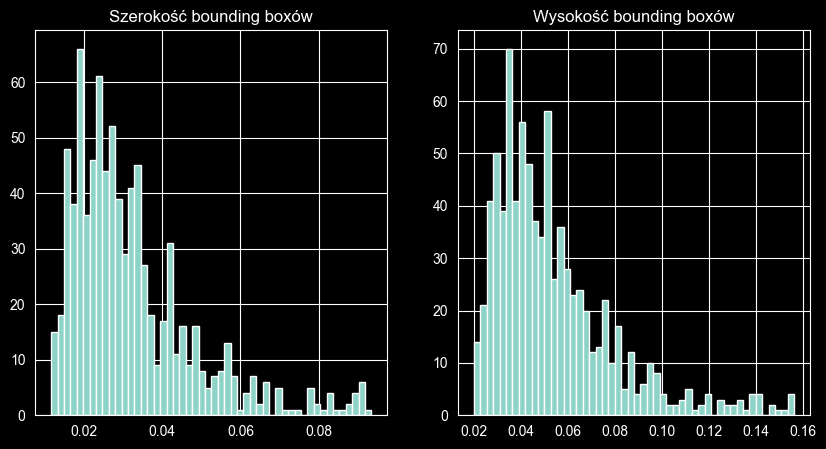

In [37]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(df['width'], bins=50)
plt.title("Szerokość bounding boxów")

plt.subplot(1,2,2)
plt.hist(df["height"], bins=50)
plt.title("Wysokość bounding boxów")
plt.show()

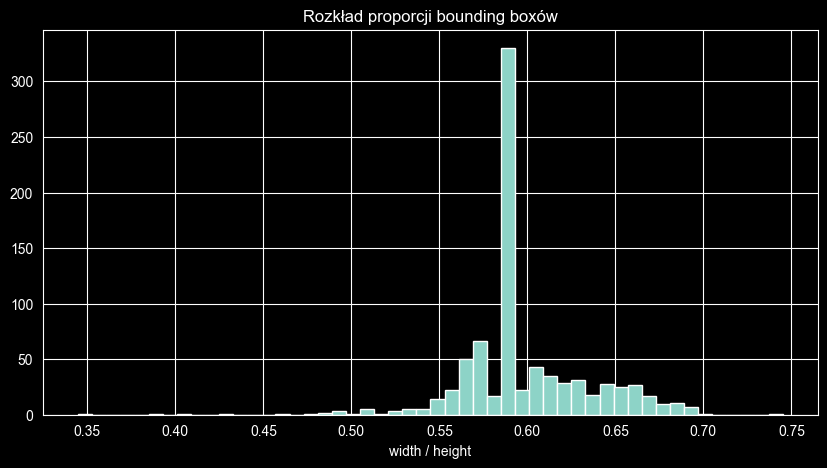

In [38]:
df["aspect_ratio"] = df["width"] / df["height"]

plt.figure(figsize=(10,5))
plt.hist(df["aspect_ratio"], bins=50)
plt.title("Rozkład proporcji bounding boxów")
plt.xlabel("width / height")
plt.show()

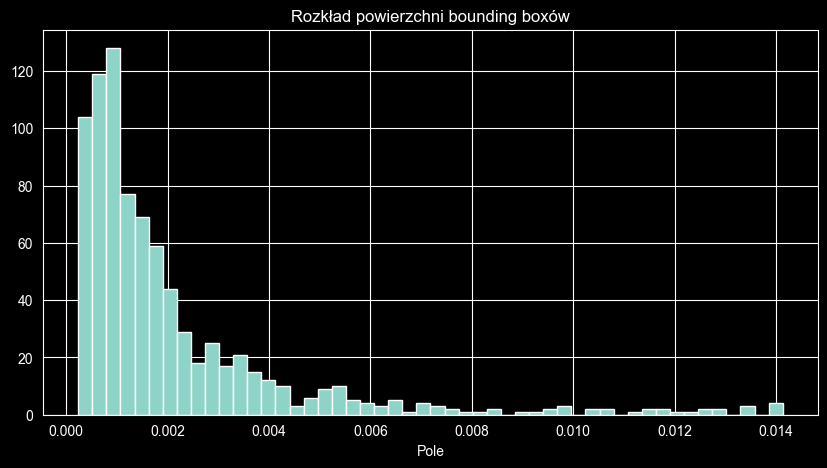

In [39]:
plt.figure(figsize=(10,5))
plt.hist(df["area"], bins=50)
plt.title("Rozkład powierzchni bounding boxów")
plt.xlabel("Pole")
plt.show()

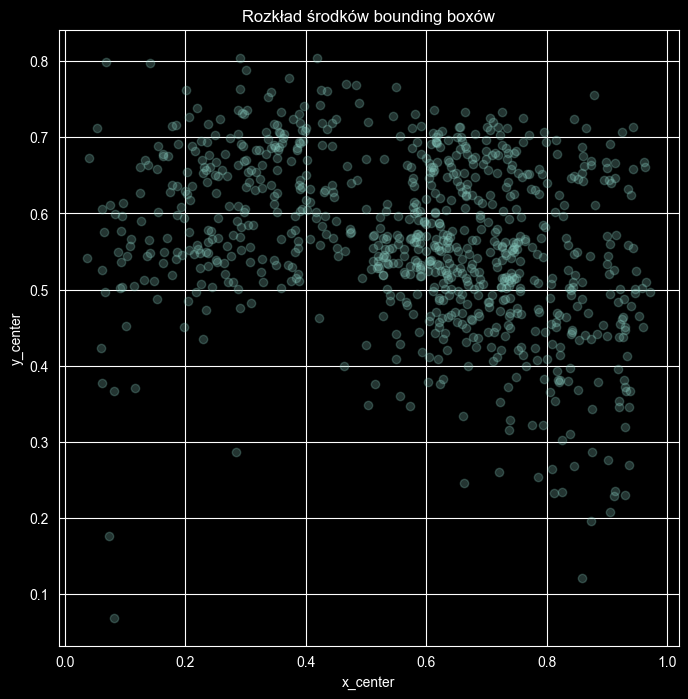

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(df["xc"], df["yc"], alpha=0.25)
plt.title("Rozkład środków bounding boxów")
plt.xlabel("x_center")
plt.ylabel("y_center")
plt.show()

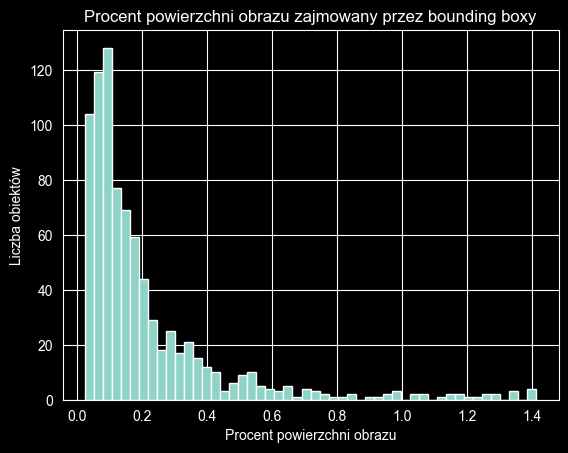

In [41]:
df["relative_area"] = df["area"] * 100

plt.hist(df["relative_area"], bins=50)
plt.xlabel("Procent powierzchni obrazu")
plt.ylabel("Liczba obiektów")
plt.title("Procent powierzchni obrazu zajmowany przez bounding boxy")
plt.show()

Rozdzielczości obrazów w zbiorze:
- 1360 × 800 px 


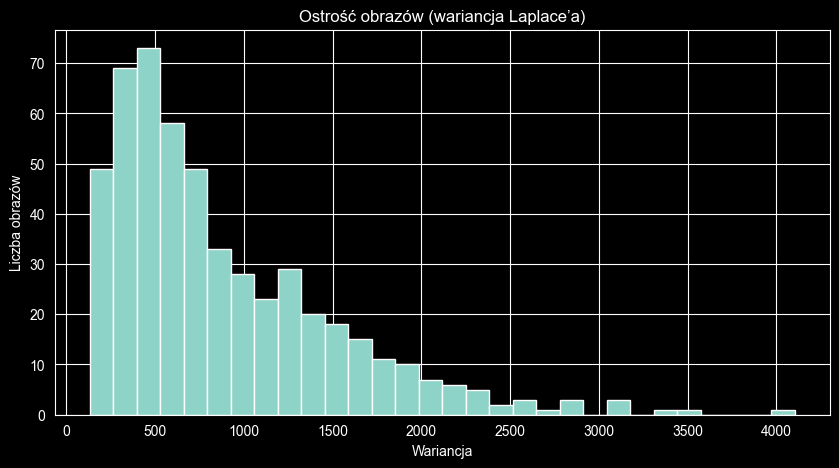

In [42]:
resolutions = []
sharpness = []

for img_path in images_dir.glob("*.png"):
    img = cv2.imread(str(img_path))

    if img is None:
        continue

    if len(img.shape) == 3:
        h, w, _ = img.shape
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        h, w = img.shape
        gray = img

    resolutions.append((w, h))
    sharpness.append(cv2.Laplacian(gray, cv2.CV_64F).var())

unique_res = set(resolutions)

print("Rozdzielczości obrazów w zbiorze:")
for w, h in unique_res:
    print(f"- {w} × {h} px ")


plt.figure(figsize=(10,5))
plt.hist(sharpness, bins=30)
plt.title("Ostrość obrazów (wariancja Laplace’a)")
plt.xlabel("Wariancja")
plt.ylabel("Liczba obrazów")
plt.show()

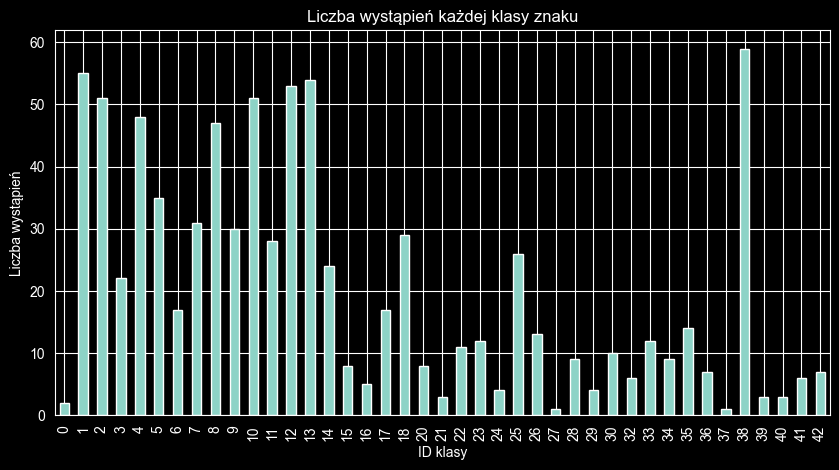

In [43]:
class_counts = df["class_id"].value_counts().sort_index()

plt.figure(figsize=(10,5))
class_counts.plot(kind="bar")
plt.title("Liczba wystąpień każdej klasy znaku")
plt.xlabel("ID klasy")
plt.ylabel("Liczba wystąpień")
plt.show()

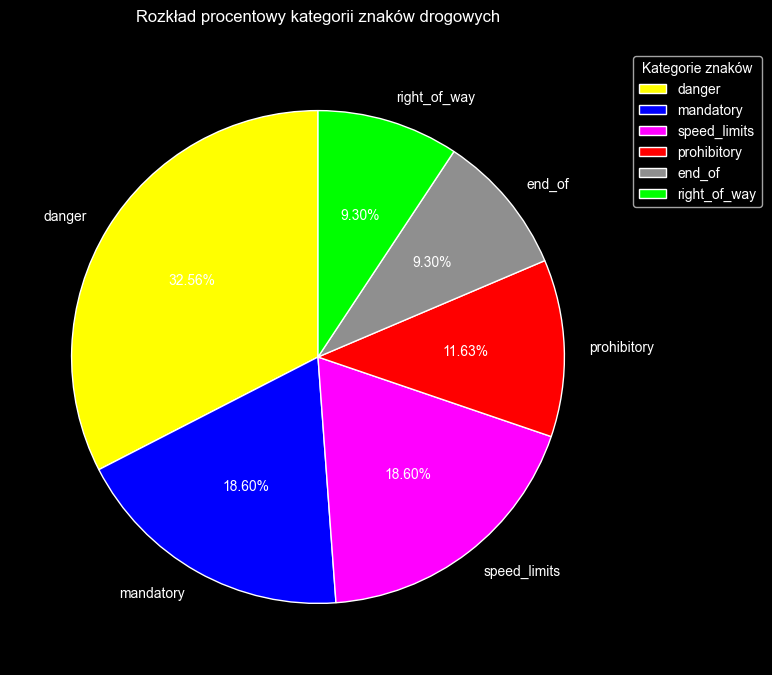


Liczba znaków w każdej kategorii:
category
danger          14
mandatory        8
speed_limits     8
prohibitory      5
end_of           4
right_of_way     4

Łącznie znaków regulacyjnych: 21


In [44]:
signs_df = pd.DataFrame({
    'class_id': list(sign_names.keys()),
    'sign_name': list(sign_names.values()),
    'category': [get_category(id) for id in sign_names.keys()]
})

category_distribution = signs_df.groupby('category')['class_id'].count().sort_values(ascending=False)
category_colors = {
    'speed_limits': '#FF00FF',
    'prohibitory': '#FF0000',
    'danger': '#FFFF00',
    'mandatory': '#0000FF',
    'right_of_way': '#00FF00',
    'end_of': '#8F8F8F'
}

plt.figure(figsize=(10,8))
patches, texts, autotexts = plt.pie(
    category_distribution,
    labels=category_distribution.index,
    autopct='%.2f%%',
    colors=[category_colors[cat] for cat in category_distribution.index],
    startangle=90
)

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title='Kategorie znaków'
)

plt.title('Rozkład procentowy kategorii znaków drogowych', pad=20)
plt.show()

print("\nLiczba znaków w każdej kategorii:")
print(category_distribution.to_string())

regulatory_categories = ['speed_limits', 'mandatory', 'prohibitory', 'end-of', 'right-of-way']

regulatory_sum = signs_df[signs_df['category'].isin(regulatory_categories)].groupby('category')['class_id'].count()
print(f"\nŁącznie znaków regulacyjnych: {regulatory_sum.sum()}")

<Figure size 1000x500 with 0 Axes>

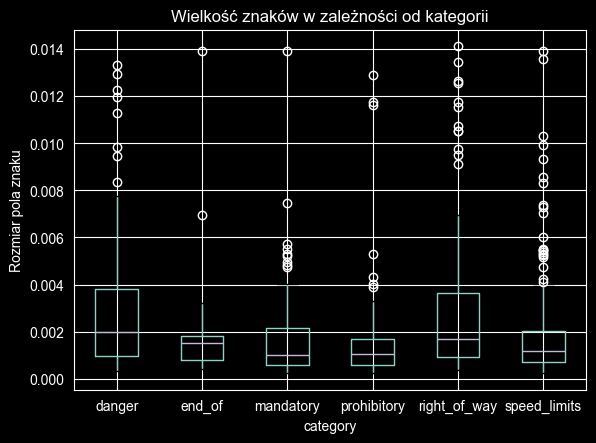

In [45]:
plt.figure(figsize=(10,5))
df.boxplot(column='area', by='category')
plt.title('Wielkość znaków w zależności od kategorii')
plt.suptitle('')
plt.ylabel('Rozmiar pola znaku')
plt.show()

In [46]:
from ultralytics import YOLO

model = YOLO("runs/detect/pierwszy_model/weights/best.pt")

results = model.predict(source="dataset/images/test", conf=0.5, save= False)


image 1/75 C:\Users\angel\PycharmProjects\TrafficSigns-YOLO\dataset\images\test\00002.png: 384x640 1 Pass on the right, 33.5ms
image 2/75 C:\Users\angel\PycharmProjects\TrafficSigns-YOLO\dataset\images\test\00016.png: 384x640 (no detections), 30.6ms
image 3/75 C:\Users\angel\PycharmProjects\TrafficSigns-YOLO\dataset\images\test\00021.png: 384x640 1 Intersection ahead  right-of-way only for this intersection, 34.1ms
image 4/75 C:\Users\angel\PycharmProjects\TrafficSigns-YOLO\dataset\images\test\00042.png: 384x640 1 Intersection ahead  right-of-way only for this intersection, 1 Stop, 29.6ms
image 5/75 C:\Users\angel\PycharmProjects\TrafficSigns-YOLO\dataset\images\test\00056.png: 384x640 1 Speed limit (30km/h), 31.7ms
image 6/75 C:\Users\angel\PycharmProjects\TrafficSigns-YOLO\dataset\images\test\00068.png: 384x640 (no detections), 31.7ms
image 7/75 C:\Users\angel\PycharmProjects\TrafficSigns-YOLO\dataset\images\test\00075.png: 384x640 1 Speed limit (50km/h), 1 Uneven road, 31.7ms
image

In [47]:
y_pred = []
y_true = []

for r in results:
    if r.boxes is None:
        continue

    pred_classes = r.boxes.cls.cpu().numpy().astype(int)
    true_labels_path = Path("dataset/labels/test") / (Path(r.path).stem + ".txt")

    if not true_labels_path.exists():
        continue

    with open(true_labels_path) as f:
        gt_classes = [int(line.split()[0]) for line in f]

    min_len = min(len(pred_classes), len(gt_classes))

    y_pred.extend(pred_classes[:min_len])
    y_true.extend(gt_classes[:min_len])


In [48]:
results_df = pd.DataFrame({
    "true_class": y_true,
    "pred_class": y_pred
})

results_df["correct"] = results_df["true_class"] == results_df["pred_class"]
results_df["category"] = results_df["true_class"].apply(get_category)

overall_accuracy = results_df["correct"].mean()
category_accuracy = results_df.groupby("category")["correct"].mean()

print("Całkowita dokładność YOLO:", overall_accuracy)
print("\nDokładność według kategorii:")
print(category_accuracy)

Całkowita dokładność YOLO: 0.5272727272727272

Dokładność według kategorii:
category
danger          0.125000
mandatory       0.555556
prohibitory     0.400000
right_of_way    0.727273
speed_limits    0.590909
Name: correct, dtype: float64


In [49]:
sign_accuracy = results_df.groupby("true_class")["correct"].mean()

sign_accuracy_df = pd.DataFrame({
    "sign_id": sign_accuracy.index,
    "sign_name": sign_accuracy.index.map(sign_names),
    "category": sign_accuracy.index.map(get_category),
    "accuracy": sign_accuracy.values
}).sort_values("accuracy", ascending=False)

print("Najlepiej rozpoznawane znaki:")
print(sign_accuracy_df.head(5).to_string(index=False))

print("\nNajgorzej rozpoznawane znaki:")
print(sign_accuracy_df.tail(5).to_string(index=False))

Najlepiej rozpoznawane znaki:
 sign_id                                                    sign_name     category  accuracy
       1                                         Speed limit (30km/h) speed_limits  1.000000
       7                                        Speed limit (100km/h) speed_limits  1.000000
       8                                        Speed limit (120km/h) speed_limits  1.000000
      11 Intersection ahead – right-of-way only for this intersection right_of_way  1.000000
      38                                            Pass on the right    mandatory  0.833333

Najgorzej rozpoznawane znaki:
 sign_id                       sign_name  category  accuracy
      27                     Pedestrians    danger       0.0
      31                    Wild animals    danger       0.0
      33                Turn right ahead mandatory       0.0
      36 Go straight or turn right ahead mandatory       0.0
      39                Pass on the left mandatory       0.0


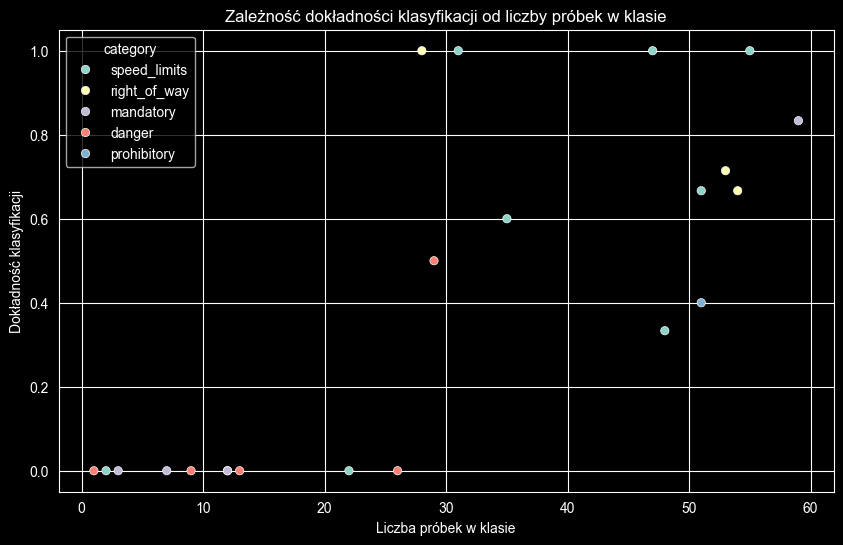

In [50]:
sample_counts = df['class_id'].value_counts().sort_index()
sign_accuracy_df['sample_count'] = sign_accuracy_df['sign_id'].map(sample_counts)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sign_accuracy_df, x='sample_count', y='accuracy', hue='category')
plt.title('Zależność dokładności klasyfikacji od liczby próbek w klasie')
plt.xlabel('Liczba próbek w klasie')
plt.ylabel('Dokładność klasyfikacji')
plt.grid(True)
plt.show()

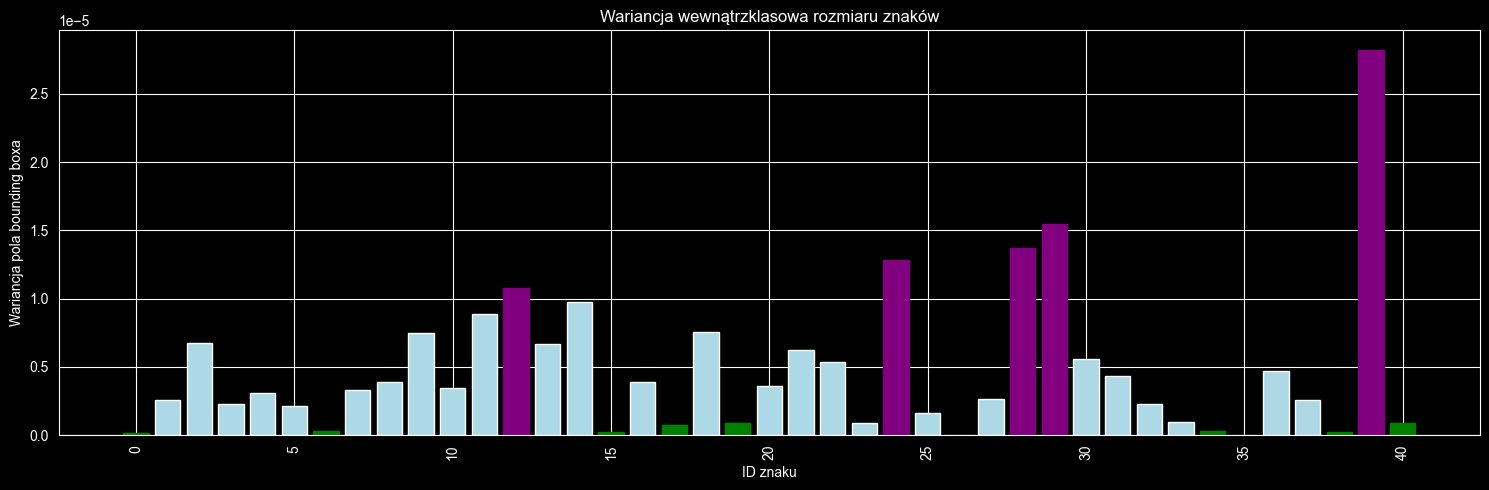

<Figure size 640x480 with 0 Axes>


Klasy o najmniejszej wariancji wewnątrzgrupowej:
 class_id                                   sign_name     category  intra_class_var  sample_count
       27                                 Pedestrians       danger     0.000000e+00             1
       37              Go straight or turn left ahead    mandatory     0.000000e+00             1
        0                        Speed limit (20km/h) speed_limits     1.571747e-07             2
       40                                  Roundabout    mandatory     2.240408e-07             3
       15           No vehicles of any kind permitted  prohibitory     2.716863e-07             8
        6                 End of speed limit (80km/h)       end_of     2.987340e-07            17
       36             Go straight or turn right ahead    mandatory     3.085313e-07             7
       17                                    No entry  prohibitory     7.828435e-07            17
       42 End of no overtaking by vehicles over 3.5 t       end_of  

In [51]:
intra_var_df = (
    df.groupby("class_id")
      .agg(
          sign_name=("sign_name", "first"),
          category=("category", "first"),
          intra_class_var=("area", "var"),
          sample_count=("area", "count")
      )
      .reset_index()

)
intra_var_df["intra_class_var"] = intra_var_df["intra_class_var"].fillna(0)

plt.figure(figsize=(15,5))
plt.title("Wariancja wewnątrzklasowa rozmiaru znaków")
plt.xlabel("ID znaku")
plt.ylabel("Wariancja pola bounding boxa")
plt.xticks(rotation=90)

x = np.arange(len(intra_var_df))
bars = plt.bar(x, intra_var_df["intra_class_var"], color="lightblue")

smallest_idx = np.argsort(intra_var_df["intra_class_var"])[:10]
largest_idx = np.argsort(intra_var_df["intra_class_var"])[-5:]

for i in smallest_idx:
    bars[i].set_color("green")
for i in largest_idx:
    bars[i].set_color("purple")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

print("\nKlasy o najmniejszej wariancji wewnątrzgrupowej:")
print(intra_var_df.iloc[smallest_idx].to_string(index=False))

print("\nKlasy o największej wariancji wewnątrzgrupowej:")
print(intra_var_df.iloc[largest_idx].to_string(index=False))

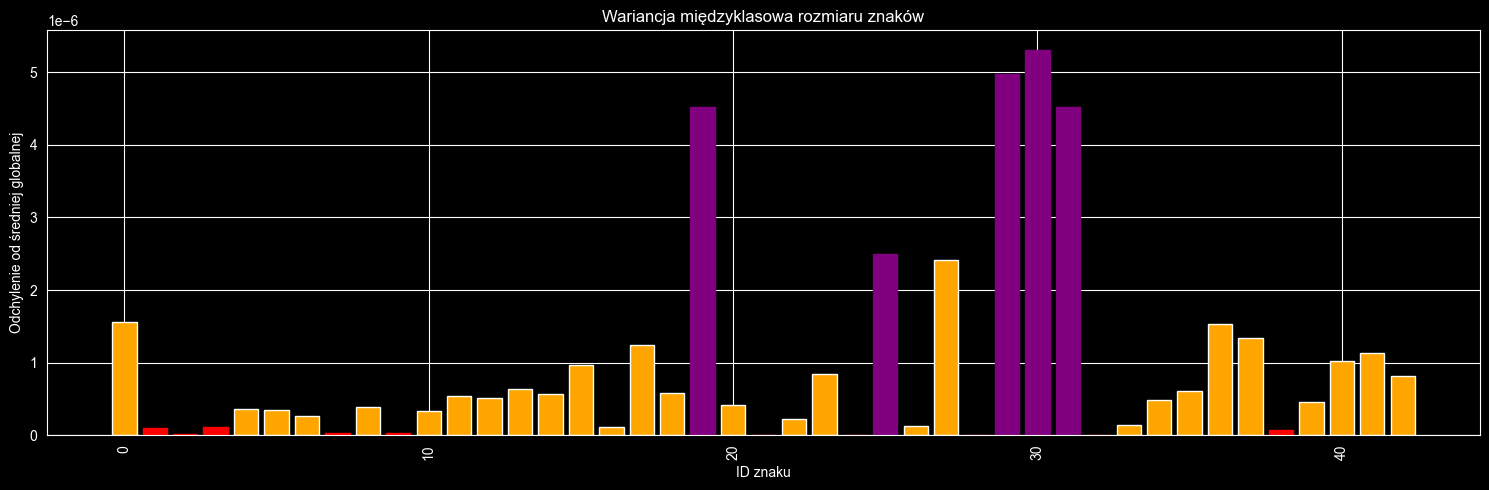

<Figure size 640x480 with 0 Axes>


Klasy o najmniejszej wariancji międzyklasowej:
 class_id                        sign_name     category  between_class_var
       24 One-sided road narrowing (right)       danger       4.608256e-11
       28                         Children       danger       5.784853e-11
       21        Double curve (first left)       danger       4.095750e-09
       32          End of all restrictions       end_of       6.852990e-09
        2             Speed limit (50km/h) speed_limits       1.597346e-08
        7            Speed limit (100km/h) speed_limits       3.376781e-08
        9                    No overtaking  prohibitory       3.471451e-08
       38                Pass on the right    mandatory       7.163798e-08
        1             Speed limit (30km/h) speed_limits       9.610179e-08
        3             Speed limit (60km/h) speed_limits       1.067198e-07

Klasy o największej wariancji międzyklasowej:
 class_id                       sign_name category  between_class_var
       25 

In [52]:
class_means = (
    df.groupby("class_id")["area"]
      .mean()
      .reindex(range(43), fill_value=0)
)

global_mean = df["area"].mean()

between_class_var = (class_means - global_mean) ** 2

between_var_df = pd.DataFrame({
    "class_id": range(43),
    "sign_name": [sign_names[i] for i in range(43)],
    "category": [get_category(i) for i in range(43)],
    "between_class_var": between_class_var.values
})

plt.figure(figsize=(15,5))
plt.title("Wariancja międzyklasowa rozmiaru znaków")
plt.xlabel("ID znaku")
plt.ylabel("Odchylenie od średniej globalnej")
plt.xticks(rotation=90)

x = np.arange(len(between_var_df))
bars = plt.bar(x, between_var_df["between_class_var"], color="orange")

smallest_idx = np.argsort(between_class_var)[:10]
largest_idx = np.argsort(between_class_var)[-5:]

for i in smallest_idx:
    bars[i].set_color("red")
for i in largest_idx:
    bars[i].set_color("purple")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

print("\nKlasy o najmniejszej wariancji międzyklasowej:")
print(between_var_df.iloc[smallest_idx].to_string(index=False))

print("\nKlasy o największej wariancji międzyklasowej:")
print(between_var_df.iloc[largest_idx].to_string(index=False))

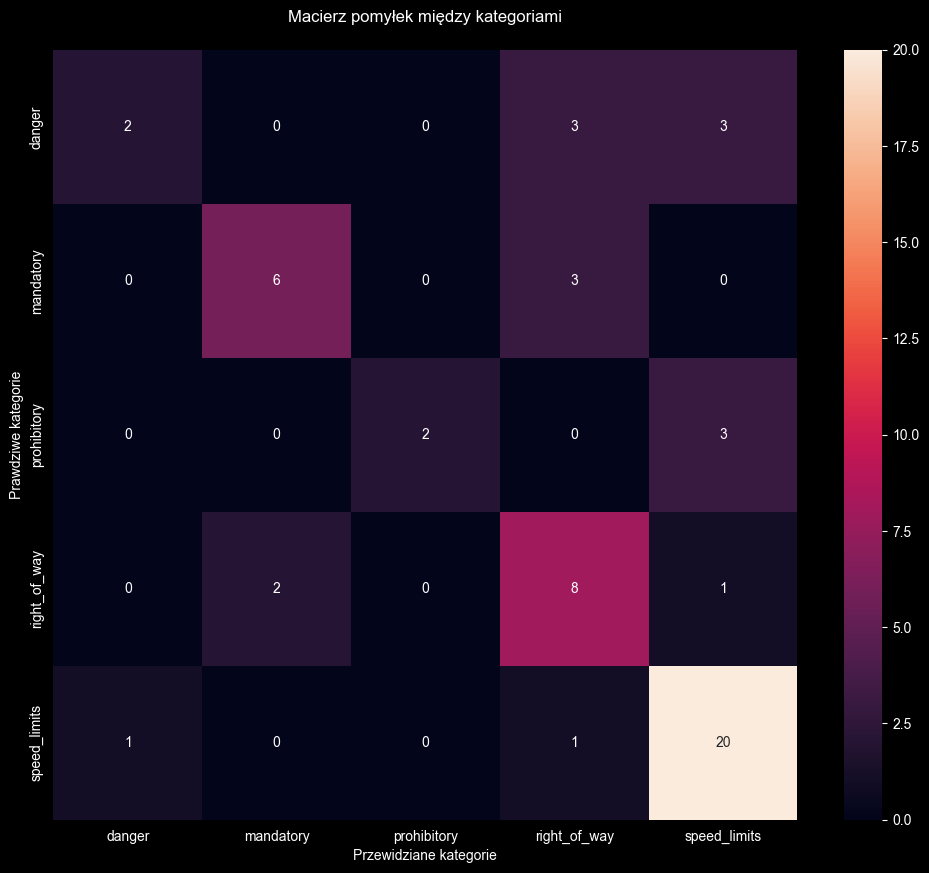

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true_cat = [get_category(x) for x in y_true]
y_pred_cat = [get_category(x) for x in y_pred]
categories_order = sorted(set(y_true_cat))

plt.figure(figsize=(12, 10))
cat_cm = confusion_matrix(y_true_cat, y_pred_cat, labels=categories_order)
sns.heatmap(cat_cm, annot=True, fmt='d',
            xticklabels=categories_order,
            yticklabels=categories_order)
plt.title('Macierz pomyłek między kategoriami', pad=20)
plt.xlabel('Przewidziane kategorie')
plt.ylabel('Prawdziwe kategorie')
plt.show()


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


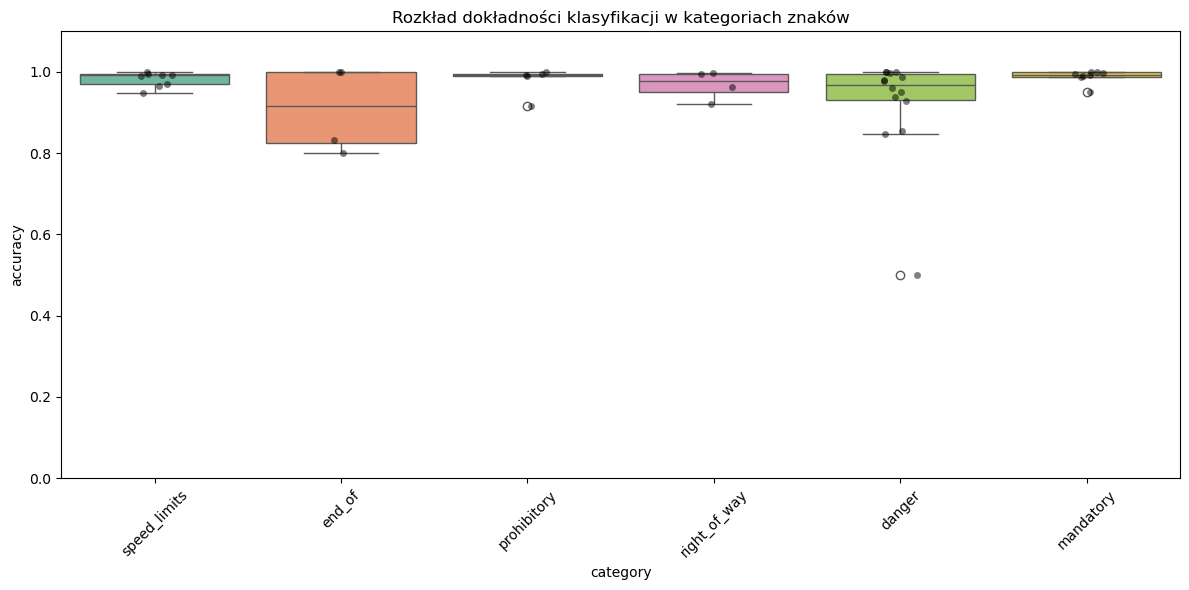

In [133]:
model = load_model("traffic_classifier.keras")
test_df = pd.read_csv('Test.csv')
y_true = test_df["ClassId"].values

y_pred = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
class_accuracy = np.diag(cm) / cm.sum(axis=1)

results_df = pd.DataFrame({
    'class_id': range(43),
    'sign_name': [sign_names[i] for i in range(43)],
    'accuracy': class_accuracy,
    'category': [get_category(i) for i in range(43)]
})

plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='accuracy', hue='category', data=results_df, 
            palette='Set2', legend=False)
sns.stripplot(x='category', y='accuracy', color='black', alpha=0.5, data=results_df)
plt.title('Rozkład dokładności klasyfikacji w kategoriach znaków')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()